In [1]:
import os

##### do smth

In [21]:
import itertools
import numpy as np
from matplotlib import pyplot as plt

In [3]:
tmp = np.random.randint(low=0, high=10, size=(3,4,5))

In [4]:
tmp

array([[[4, 4, 4, 6, 1],
        [8, 2, 7, 3, 5],
        [4, 2, 5, 1, 2],
        [9, 4, 6, 7, 1]],

       [[2, 9, 6, 3, 8],
        [9, 7, 1, 6, 6],
        [6, 5, 5, 1, 1],
        [2, 8, 5, 0, 2]],

       [[5, 1, 2, 3, 4],
        [5, 6, 8, 0, 0],
        [1, 2, 6, 5, 6],
        [0, 7, 7, 0, 6]]])

In [8]:
tmp[1,1]

array([9, 7, 1, 6, 6])

In [9]:
tmp[(1,1)]

array([9, 7, 1, 6, 6])

In [12]:
mask = [True, False, True, True, True]

In [13]:
tmp[(1,1)][mask]

array([9, 1, 6, 6])

In [17]:
tmp[np.array([1,1])]

array([[[2, 9, 6, 3, 8],
        [9, 7, 1, 6, 6],
        [6, 5, 5, 1, 1],
        [2, 8, 5, 0, 2]],

       [[2, 9, 6, 3, 8],
        [9, 7, 1, 6, 6],
        [6, 5, 5, 1, 1],
        [2, 8, 5, 0, 2]]])

In [19]:
(1,2) == (1,2)

True

##### Define world map

In [20]:
reward_points = [
    {
        'pos': (0,3),
        't': np.arange(0,10),
        'reward': np.ones(shape=(10,))
    },
    {
        'pos': (1,3),
        't': np.arange(0,10),
        'reward': -6 * np.ones(shape=(10,)) 
    }
]


def get_reward(x, t, reward_points):
    
    rew = sum([el['reward'][t] for el in reward_points if el['pos'] == x])
    return rew


In [26]:
t = 0
d0, d1 = 3, 4

reward = np.zeros(shape=(d0, d1))


for x in itertools.product(range(d0), range(d1)):    
    reward[x] = get_reward(x, t, reward_points)

In [27]:
reward

array([[ 0.,  0.,  0.,  1.],
       [ 0.,  0.,  0., -6.],
       [ 0.,  0.,  0.,  0.]])

In [136]:
from typing import List, Tuple

def kd(a, b):
    """ kd = kronecker delta
    """
    return 1 if a == b else 0

def get_rho(lam: np.ndarray, mask: np.ndarray):
    """
    :param lam:
    :param mask:
    :return:
    """
    r = np.zeros(shape=(len(mask),))

    if any(mask):
        r_ = np.exp(lam[mask])
        r_ = r_ / r_.sum()
        r[mask] = r_

    return r

def get_mask(x: Tuple[int, int], impenetrables: List[Tuple[int, int]]):
    """
    mask legend:
    [stay, up, down, right, left]

    :param x: current position
    :param impenetrables: set of impenetrable points
    """

    # TODO: do I need the if condition?
    if x in impenetrables:
        mask = np.zeros(5).astype(bool)
    else:
        mask = np.logical_not(
            np.array([
                sum(kd((x[0], x[1]), d) for d in impenetrables),  # stay
                sum(kd((x[0] - 1, x[1]), d) for d in impenetrables),  # move up
                sum(kd((x[0] + 1, x[1]), d) for d in impenetrables),  # move down
                sum(kd((x[0], x[1] + 1), d) for d in impenetrables),  # move right
                sum(kd((x[0], x[1] - 1), d) for d in impenetrables)  # move left
            ]))

    return mask

def get_p_xf_xi(xf, xi, lam, mask):
    rho = get_rho(lam, mask)

    p_xf_xi = \
        kd(xf, (xi[0], xi[1])) * rho[0] + \
        kd(xf, (xi[0] - 1, xi[1])) * rho[1] + \
        kd(xf, (xi[0] + 1, xi[1])) * rho[2] + \
        kd(xf, (xi[0], xi[1] + 1)) * rho[3] + \
        kd(xf, (xi[0], xi[1] - 1)) * rho[4]

    return p_xf_xi

def get_grad_p_xf_xi(xf, xi, lam, mask):
    rho = get_rho(lam, mask)
    p_xf_xi = get_p_xf_xi(xf, xi, lam, mask)

    grad_p_xf_xi = - rho * p_xf_xi

    grad_p_xf_xi += np.array([
        kd(xf, (xi[0], xi[1])) * rho[0],
        kd(xf, (xi[0] - 1, xi[1])) * rho[1],
        kd(xf, (xi[0] + 1, xi[1])) * rho[2],
        kd(xf, (xi[0], xi[1] + 1)) * rho[3],
        kd(xf, (xi[0], xi[1] - 1)) * rho[4]
    ])

    return grad_p_xf_xi

def get_all_grad_p_xf_xi(xi, lam, mask, d0, d1):

    all_grad_xf = np.zeros(shape=(d0,d1,5))
    
    for xf in itertools.product(range(d0), range(d1)):
        all_grad_xf[xf] = get_grad_p_xf_xi(xf, xi, lam, mask)
            
    return all_grad_xf.transpose(2,0,1)  # shape = (5, d0, d1)

In [41]:
rho = get_rho(lam=np.array([1,2,3,4, 5]), mask=[False, True, False, True, True])
rho, rho.sum()

(array([0.        , 0.03511903, 0.        , 0.25949646, 0.70538451]), 1.0)

In [42]:
rho = get_rho(lam=np.array([1,2,3,4, 5]), mask=[False, False, False, False, False])
rho, rho.sum()

(array([0., 0., 0., 0., 0.]), 0.0)

In [44]:
impenetrable_points = \
    [(-1, el) for el in range(d1)] + \
    [(d0, el) for el in range(d1)] + \
    [(el, -1) for el in range(d0)] + \
    [(el, d1) for el in range(d0)] + \
    [(1,1)]


In [45]:
impenetrable_points

[(-1, 0),
 (-1, 1),
 (-1, 2),
 (-1, 3),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 3),
 (0, -1),
 (1, -1),
 (2, -1),
 (0, 4),
 (1, 4),
 (2, 4),
 (1, 1)]

In [63]:
masks = np.ones(shape=(d0,d1,5)).astype(bool)
masks

array([[[ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True]],

       [[ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True]],

       [[ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True]]])

In [64]:
for x in itertools.product(range(d0), range(d1)):

    masks[x] = get_mask(x=x, impenetrables=impenetrable_points)

In [65]:
masks

array([[[ True, False,  True,  True, False],
        [ True, False, False,  True,  True],
        [ True, False,  True,  True,  True],
        [ True, False,  True, False,  True]],

       [[ True,  True,  True, False, False],
        [False, False, False, False, False],
        [ True,  True,  True,  True, False],
        [ True,  True,  True, False,  True]],

       [[ True,  True, False,  True, False],
        [ True, False, False,  True,  True],
        [ True,  True, False,  True,  True],
        [ True,  True, False, False,  True]]])

In [66]:
masks[(2,0)]

array([ True,  True, False,  True, False])

In [76]:
# np.set_printoptions(edgeitems=10)
np.core.arrayprint._line_width = 180

In [87]:
lam = np.array([0,1,2,3,4])
xi = (2,3)

all_xf = np.zeros(shape=(d0,d1))

for xf in itertools.product(range(d0), range(d1)):
    all_xf[xf] = get_p_xf_xi(xf, xi, lam, masks[xi])

print(all_xf)
print('\n', all_xf.sum())

[[0.         0.         0.         0.        ]
 [0.         0.         0.         0.04661262]
 [0.         0.         0.93623955 0.01714783]]

 1.0


In [89]:
lam = np.array([0,1,2,3,4])
xi = (2,3)

all_grad_xf = np.zeros(shape=(d0,d1,5))

for xf in itertools.product(range(d0), range(d1)):
    all_grad_xf[xf] = get_grad_p_xf_xi(xf, xi, lam, masks[xi])
    
# print(all_xf)
# print('\n', all_xf.sum())

In [91]:
print(all_grad_xf)

[[[ 0.          0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.        ]
  [-0.00079931  0.04443989  0.          0.         -0.04364058]]

 [[ 0.          0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.        ]
  [-0.01605447 -0.04364058  0.          0.          0.05969505]
  [ 0.01685378 -0.00079931  0.          0.         -0.01605447]]]


In [99]:
all_grad_xf[(1,3)]

array([-0.00079931,  0.04443989,  0.        ,  0.        , -0.04364058])

##### summarize everything

In [100]:
t = 0
d0, d1 = 3, 4

In [102]:
rewards = np.zeros(shape=(d0, d1))
masks = np.ones(shape=(d0,d1,5)).astype(bool)

for x in itertools.product(range(d0), range(d1)):    
    rewards[x] = get_reward(x, t, reward_points)
    masks[x] = get_mask(x, impenetrable_points)

In [104]:
v_star = np.zeros(shape=(d0, d1))

In [200]:
t_max=6
alpha = 0.1
gamma = 0.95


max_iterations = 10000

lams = np.zeros(shape=(t_max,d0,d1,5)) # np.random.randn(d0,d1,5)*0.1  # np.zeros(shape=(d0,d1,5))
rhos = np.zeros(shape=(t_max,d0,d1,5))
v_stars = np.zeros(shape=(t_max,d0,d1))



for tau in np.arange(0, t_max)[::-1]:
    
    gamma_tau = gamma ** tau

    for xi in itertools.product(range(d0), range(d1)):

        mask = masks[xi]
        lam = lams[tau][xi]        
        rho, rho_prev = get_rho(lam, mask), None
        v_star = np.zeros(shape=(d0,d1)) if tau == t_max-1 else v_stars[tau+1]
        
        for it in range(max_iterations):

            all_grad_xf = get_all_grad_p_xf_xi(xi, lam, mask, d0, d1)
            
            d_lam = ((gamma * v_star + gamma_tau * rewards) * all_grad_xf).sum(axis=(1,2))            
            
#             d_lam = sum([
#                 (gamma * v_star[xf] + gamma_tau * rewards[xf]) * get_grad_p_xf_xi(xf, xi, lam, mask) 
#                 for xf in x_all])

            lam += alpha * d_lam

            rho_prev = rho
            rho = get_rho(lam, mask)

            if np.linalg.norm((rho - rho_prev)) < 10 ** -6:
                break

        lams[tau][xi] = lam
        rhos[tau][xi] = rho
        
        v_stars[tau][xi] = sum([
            (gamma * v_star[xf] + gamma_tau * rewards[xf]) * get_p_xf_xi(xf, xi, lam, mask)
            for xf in itertools.product(range(d0), range(d1))
        ])

        

In [201]:
np.round(rhos[0], 2).transpose(2,0,1)

array([[[0.  , 0.  , 0.  , 1.  ],
        [0.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.  ]],

       [[0.  , 0.  , 0.  , 0.  ],
        [1.  , 0.  , 1.  , 1.  ],
        [0.64, 0.  , 1.  , 0.  ]],

       [[0.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.  ]],

       [[1.  , 1.  , 1.  , 0.  ],
        [0.  , 0.  , 0.  , 0.  ],
        [0.36, 1.  , 0.  , 0.  ]],

       [[0.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , 1.  ]]])

##### use library

In [2]:
pwd

'/Users/A.IVA/Documents/jupyter_notebooks/coursera_and_blogs/pytorch/rl'

In [2]:
from src.m01_refactored import get_path, plot_rho
import numpy as np

In [3]:
d0 = 3
d1 = 4
t_max = 7

params = {
    'd0': d0,
    'd1': d1,
    't_max': t_max,
    'alpha': 0.1,
    'gamma': 1,
    'max_iterations': 10000
}

reward_points = [
    {
        'pos': (0,3),
        't': np.arange(0,t_max),
        'reward': np.ones(shape=(t_max,))
    },
    {
        'pos': (1,3),
        't': np.arange(0,t_max),
        'reward': -6 * np.ones(shape=(t_max,)) 
    }
]

impenetrable_points = \
    [(-1, el) for el in range(d1)] + \
    [(d0, el) for el in range(d1)] + \
    [(el, -1) for el in range(d0)] + \
    [(el, d1) for el in range(d0)] + \
    [(1,1)]

In [4]:
result = get_path(params=params,
                  impenetrable_points=impenetrable_points,
                  reward_points=reward_points)

tau = 6
tau = 5
tau = 4
tau = 3
tau = 2
tau = 1
tau = 0


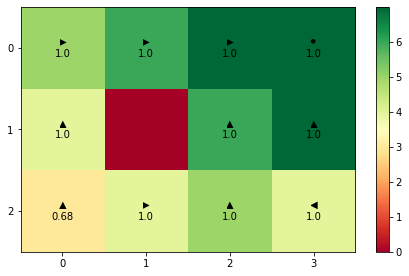

In [5]:
plot_rho(V=result['v_stars'][0], 
         probabilities=result['rhos'][0], 
         impenetrable_points=impenetrable_points, 
         d0=d0, 
         d1=d1)

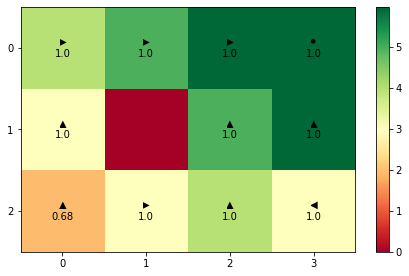

In [6]:
plot_rho(V=result['v_stars'][1], 
         probabilities=result['rhos'][1], 
         impenetrable_points=impenetrable_points, 
         d0=d0, 
         d1=d1)

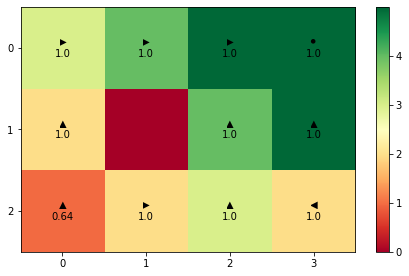

In [20]:
plot_rho(V=result['v_stars'][2], 
         probabilities=result['rhos'][2], 
         impenetrable_points=impenetrable_points, 
         d0=d0, 
         d1=d1)

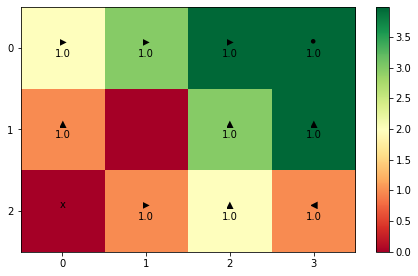

In [19]:
plot_rho(V=result['v_stars'][3], 
         probabilities=result['rhos'][3], 
         impenetrable_points=impenetrable_points, 
         d0=d0, 
         d1=d1)

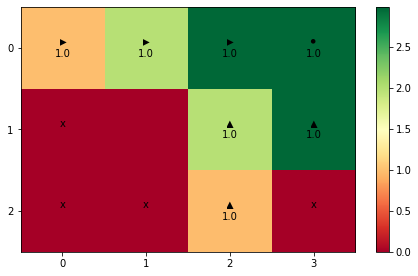

In [17]:
plot_rho(V=result['v_stars'][4], 
         probabilities=result['rhos'][4], 
         impenetrable_points=impenetrable_points, 
         d0=d0, 
         d1=d1)

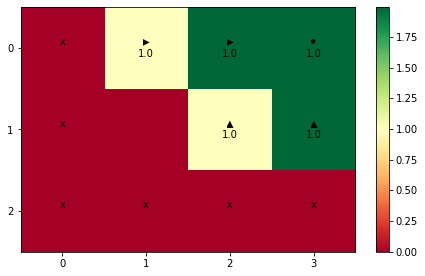

In [16]:
plot_rho(V=result['v_stars'][5], 
         probabilities=result['rhos'][5], 
         impenetrable_points=impenetrable_points, 
         d0=d0, 
         d1=d1)

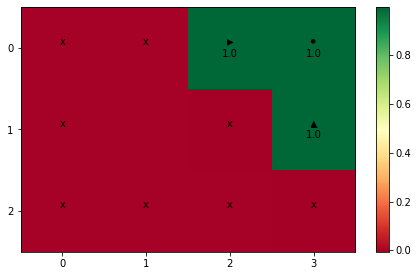

In [15]:
plot_rho(V=result['v_stars'][6], 
         probabilities=result['rhos'][6], 
         impenetrable_points=impenetrable_points, 
         d0=d0, 
         d1=d1)

In [21]:
2+2

4

In [25]:
result['v_stars'][6].shape

(3, 4)

In [34]:
import itertools
V=np.zeros(shape=(3,4))
V[(1,1)] = 1

# for i,j in itertools.product(range(d0), range(d1)):
#     V[(i,j)] = i+j

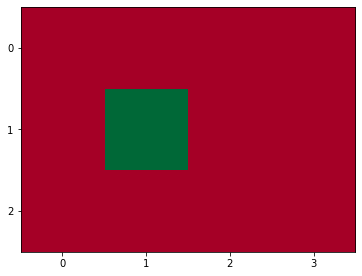

In [35]:
fig = plt.figure(figsize=(1.5 * d1, 1.5 * d0))

ax = fig.add_subplot(1, 1, 1, xticks=np.arange(d1), yticks=np.arange(d0))
plt.imshow(V, interpolation='none', aspect='auto', cmap='RdYlGn')
# plt.colorbar()
arrows = [u'\u26ab', '\u25b2', '\u25bc', '\u25b6', '\u25c0']

# for (i, j), v in np.ndenumerate(np.around(V, 2)):
#     label = ''
#     if (i, j) not in impenetrable_points:
#         if v < 0.01:
#             label = "x\n "
#         else:
#             probability_vec = probabilities[(i, j)]
#             direction = arrows[np.argmax(probability_vec)]
#             prob = np.max(np.round(probability_vec, 2))
#             label = f"{direction}\n{prob}"

#     plt.gca().text(j, i, label, ha='center', va='center')

plt.show()